## Shoes Classification with Transfer Learning 

In [198]:
import os, cv2
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

from PIL import Image
from torchvision import datasets, transforms, utils, models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

SEED = 7

In [199]:
def get_classes(root):
    assert os.path.exists(root), 'No path or file found'
    # get number of classes from the folder name and put as dict
    classes = [c for c in os.listdir(root) if os.path.isdir(os.path.join(root, c))]
    classes.sort()
    class_dict = {val: num for num, val in enumerate(classes)}
    print("Total classes found in dataset:", len(classes))
    return classes, class_dict

def get_image(root, classes, type):
    image_type = type

    file_paths = []
    file_labels = []
    file_errors = []
    
    for c in classes:
        path_all_classes = os.path.join(root, c)
        # list all files and creat path to file that contain input file type
        for file in os.listdir(path_all_classes):
            if os.path.splitext(file)[1] in image_type:
                file_paths.append(os.path.join(path_all_classes, file))
                file_labels.append(c)
            else:
                file_errors.append(os.path.join(path_all_classes, file))
        
    df_store = pd.DataFrame( list(zip(file_paths,file_labels)), columns=['Filepaths','Labels'])
    class_len = np.array(df_store.groupby('Labels').count().values).reshape(-1)

    print("Total images found in dataset:", np.sum(class_len))
    print("Total error files type found:", np.sum(file_errors).astype(int))
    
    return df_store, file_errors

# Not using this function as datasets provide separate folders of Train, Valid, Test set
def split_train_data(df, size, stratify):
    
    if stratify:
        # set stratify to set every classes with same distribution
        df_train, df_test = train_test_split(df, train_size=size, random_state=SEED, shuffle=True, stratify=df['Labels'])
    else:
        df_train, df_test = train_test_split(df, train_size=size, random_state=SEED, shuffle=True)

    print("Train data: %d" %(len(df_train)), "Test data: %d" %(len(df_test)))
    return df_train, df_test

### Load Train, Test, Valid classes from root

In [200]:
root = 'Shoes Dataset/Train/'
image_types = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']

classes, class_dict_train = get_classes(root)
df_fapth, ferror = get_image(root, classes, image_types)
#df_traindata, df_testdata = split_train_data(df_fapth, 0.8, stratify=True)

Total classes found in dataset: 5
Total images found in dataset: 10000
Total error files type found: 0


In [201]:
root_val = 'Shoes Dataset/Valid/'

classes_val, class_dict_val = get_classes(root_val)
df_fapth_val, ferror_val = get_image(root_val, classes_val, image_types)

Total classes found in dataset: 5
Total images found in dataset: 2500
Total error files type found: 0


In [202]:
root_test = 'Shoes Dataset/Test/'

classes_test, class_dict_test = get_classes(root_test)
df_fapth_test, ferror_test = get_image(root_test, classes_test, image_types)

Total classes found in dataset: 5
Total images found in dataset: 1215
Total error files type found: 0


### Check classes distribution of train data

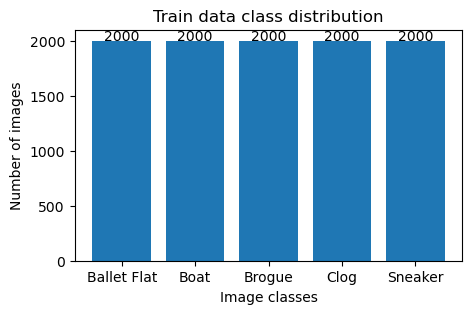

In [203]:
total_train_class = df_fapth.groupby('Labels').count().values.reshape(-1)

plt.subplots(figsize=((5,3)))
plt.bar(range(len(classes)), total_train_class, align='center')
plt.xticks(range(len(classes)), df_fapth.groupby('Labels').count().index)

for i, v in enumerate(total_train_class):
     plt.text(x=i, y=v + 5, s=str(v), ha='center')

plt.xlabel('Image classes')
plt.ylabel('Number of images')

plt.title('Train data class distribution')
plt.show()

### Custom Dataset class for dataloader

In [204]:
# Custom data loader for dataset which stored images and labels
class CDataset(Dataset):
    
    def __init__(self, image_path, image_labels, transform=None):
        
        super().__init__()
        self.image_path = image_path
        self.image_class = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx):
        
        #if torch.is_tensor(idx):
            #idx = idx.tolist()
            
        image = Image.open(self.image_path[idx]).convert('RGB')
        label = self.image_class[idx]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label
    
    @staticmethod
    def collate_fn(batch):
        images, labels = tuple(zip(*batch))
        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

In [205]:
# Split train,valid,test dataframe columns to path and label

train_img_path = df_fapth['Filepaths'].tolist()
train_img_label = [class_dict_train[i] for i in df_fapth['Labels'].tolist()]

valid_img_path = df_fapth_val['Filepaths'].tolist()
valid_img_label = [class_dict_val[i] for i in df_fapth_val['Labels'].tolist()]

test_img_path = df_fapth_test['Filepaths'].tolist()
test_img_label = [class_dict_test[i] for i in df_fapth_test['Labels'].tolist()]

In [206]:
# Using the mean and std of Imagenet in normalize, including img size. They are calculated based on millions of images.
data_transform = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224), 
                                 transforms.ToTensor(), 
                                 transforms.RandomHorizontalFlip(), 
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'valid': transforms.Compose([transforms.Resize((224, 224)), 
                                 transforms.CenterCrop(200), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'test': transforms.Compose([transforms.Resize((224, 224)), 
                                 transforms.CenterCrop(200), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

batch_size = 32

train_dataset = CDataset(train_img_path, train_img_label, transform=data_transform['train'])
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0, collate_fn=train_dataset.collate_fn)

valid_dataset = CDataset(valid_img_path, valid_img_label, transform=data_transform['valid'])
validloader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, num_workers=0, collate_fn=valid_dataset.collate_fn)

test_dataset = CDataset(test_img_path, test_img_label, transform=data_transform['test'])
testloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=0, collate_fn=test_dataset.collate_fn)

### Select transfer learning by choosing efficientnet b1 model for shoes classification

In [207]:
model_transfer = models.efficientnet_b1(pretrained=True)

C:\Users\Lenovo\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [208]:
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')

model_transfer = model_transfer.to(device)

# selecting loss function
criterion_transfer = nn.CrossEntropyLoss()

#using Adam classifier
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.0003, weight_decay=0.0002)

In [209]:
def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, device, save_path):
    trainingloss = []
    validationloss = []
    valid_loss_min = np.Inf 

    for epoch in range(n_epochs):
        #train_loss = 0
        #valid_loss = 0
        
        best_valid_acc = 0
        train_acc = 0
        valid_acc = 0
        running_loss = 0 
        
        model.train()
        for batch_idx, (data) in enumerate(train_loader):
            # move to GPU
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() #* inputs.size(0)
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            loss.backward()
            optimizer.step()
            
            # calculate train accuracy
            train_acc += (torch.argmax(outputs, dim=1) == labels).sum().item() 

        # validating the model #
        model.eval()
        with torch.no_grad():
            
            for batch_idx, (data) in enumerate(valid_loader):
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                #valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
                # calculate valid accuracy
                valid_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()

        train_acc = train_acc/len(train_dataset)
        valid_acc = valid_acc/len(valid_dataset)

        #trainingloss.append(train_loss)
        #validationloss.append(valid_loss)

        print(f'epoch [{epoch+1}/{n_epochs}] train_accuracy: {train_acc:.3f} validation_accuracy: {valid_acc:.3f} running_loss: {running_loss:.3f}')

        ## saving the model if valid accuracy has decreased
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), save_path)
            
    return model, trainingloss, validationloss

In [210]:
save_path = './EfficientNetB1.pth'
epochs = 10

model_transfer, train_loss, valid_loss = train(epochs, trainloader, validloader, model_transfer, optimizer_transfer, criterion_transfer, device, save_path)

epoch [1/10] train_accuracy: 0.669 validation_accuracy: 0.828 running_loss: 366.956
epoch [2/10] train_accuracy: 0.797 validation_accuracy: 0.832 running_loss: 180.988
epoch [3/10] train_accuracy: 0.819 validation_accuracy: 0.861 running_loss: 160.338
epoch [4/10] train_accuracy: 0.843 validation_accuracy: 0.873 running_loss: 142.568
epoch [5/10] train_accuracy: 0.853 validation_accuracy: 0.876 running_loss: 129.533
epoch [6/10] train_accuracy: 0.861 validation_accuracy: 0.877 running_loss: 119.764
epoch [7/10] train_accuracy: 0.869 validation_accuracy: 0.886 running_loss: 114.381
epoch [8/10] train_accuracy: 0.870 validation_accuracy: 0.872 running_loss: 111.229
epoch [9/10] train_accuracy: 0.880 validation_accuracy: 0.884 running_loss: 104.573
epoch [10/10] train_accuracy: 0.885 validation_accuracy: 0.874 running_loss: 101.882


In [211]:
def prediction(model, test_loader,criterion, classes):
    
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    error = 0
    test_loss = 0
    y_pred = []
    y_true = []
    
    
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item() * images.size(0)
            
            prediction = output.data.max(1, keepdim=True)[1]
            
            # store y_pred and y_true to calculate metric score
            for i in range(len(prediction)):
                y_pred.append(prediction[i].cpu().numpy())
                y_true.append(labels[i].cpu().numpy())
            
            # compare prediction and true labels
            correct_tensor = prediction.eq(labels.data.view_as(prediction))
            correct = np.squeeze(correct_tensor.cpu().numpy())    
            
            # count correct prediction for each classes to calculate accuracy 
            for i in range(len(correct)):
                label = labels.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
        # average test loss
        test_loss = test_loss/len(test_loader.dataset)
        print('Test Loss: {:.3f}\n'.format(test_loss))
        
        for i in range(len(classes)):
            if class_total[i] > 0:
                print('Test Accuracy of %10s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
            else:
                print('Test Accuracy of %10s: N/A (no training examples)' % (classes[i]))
        
        accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
        print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
            accuracy, np.sum(class_correct), np.sum(class_total)))
        
    return np.array(y_true), np.array(y_pred).reshape(-1)        

In [212]:
# load model and run prediction on valid dataset which return array of prediction and true labels to use in report and analyze
model_transfer.load_state_dict(torch.load(save_path))

ytrue, ypred = prediction(model_transfer, testloader, criterion_transfer, classes_test)

Test Loss: 0.528

Test Accuracy of Ballet Flat: 81% (79/97)
Test Accuracy of       Boat: 73% (173/236)
Test Accuracy of     Brogue: 96% (185/192)
Test Accuracy of       Clog: 85% (363/424)
Test Accuracy of    Sneaker: 90% (241/266)

Test Accuracy (Overall): 85% (1041/1215)


## The model use test data that does not feed into training process which appear the overall accuracy is 85% 

In [213]:
clr = classification_report(ytrue, ypred, target_names=classes_test, digits=3)
print("Classification Report:\n\n", clr)

Classification Report:

               precision    recall  f1-score   support

 Ballet Flat      0.745     0.814     0.778        97
        Boat      0.840     0.733     0.783       236
      Brogue      0.815     0.964     0.883       192
        Clog      0.948     0.856     0.900       424
     Sneaker      0.823     0.906     0.862       266

    accuracy                          0.857      1215
   macro avg      0.834     0.855     0.841      1215
weighted avg      0.862     0.857     0.856      1215



Text(0.5, 1.0, 'Confusion Matrix')

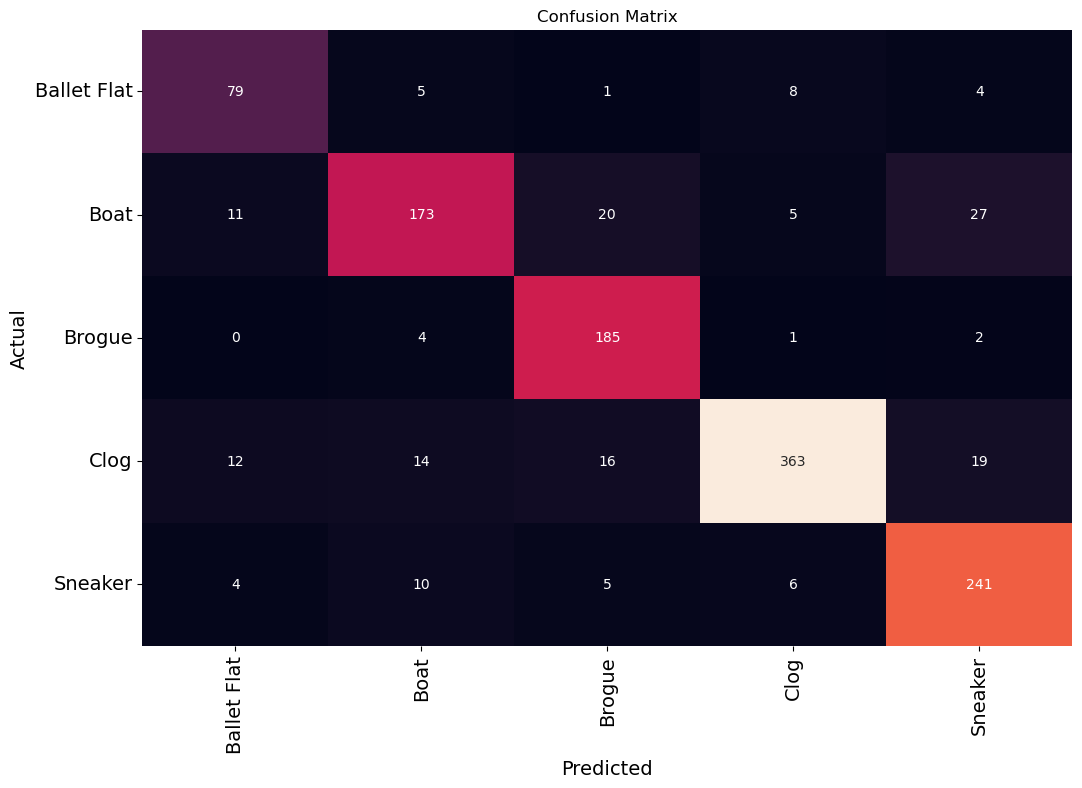

In [214]:
con_mat = confusion_matrix(ytrue, ypred)
plt.figure(figsize=(12, 8))
#plt.subplot(1, 2, 1)
sns.heatmap(con_mat, annot=True, vmin=0, fmt='g', cbar=False)
plt.xticks(np.arange(len(classes_test)) + .5, classes, rotation=90, fontsize=14)
plt.yticks(np.arange(len(classes_test)) + .5, classes, rotation=0, fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.title("Confusion Matrix")